# Setup

In [1]:
# VGG16 reference: https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch
# PyTorch data preprocessing reference: https://www.kaggle.com/altanai/garbage-segrigation-on-pytorch-95-accuracy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

#Set the run time to be GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [2]:
from google.colab import drive
drive.mount("/content/drive")
data_dir = "/content/drive/My Drive/garbage_data/Garbage_classification/Garbage_classification"

classes = os.listdir(data_dir)
print(classes)

Mounted at /content/drive
['trash', 'glass', 'cardboard', 'paper', 'metal', 'plastic']


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Transform the image to be size 28 * 28
transformations = transforms.Compose([ transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder(data_dir, transform = transformations)

dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /content/drive/My Drive/garbage_data/Garbage_classification/Garbage_classification
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [4]:
#A helper function to see image and its corresponding label
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cardboard (Class No: 0)


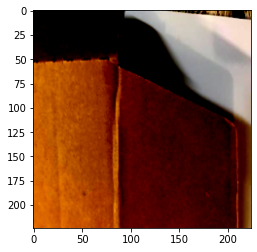

In [5]:
img, label = dataset[17]
show_sample(img, label)

# Loading Data

In [6]:
# Set Random Seed
random_seed = 42
torch.manual_seed(random_seed)

In [7]:
from torch.utils import data
train_ds, val_ds, test_ds = data.random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [8]:
train_ds

In [9]:
val_ds

In [10]:
test_ds

In [11]:
# from torch.utils.data import ConcatDataset

# aug_flag = 1 # 0: no augmentation; 1: augmentation

# class dataAug():
#   def __init__(self,data,transforms = None):
#     self.data = data
#     self.transforms = transforms
#   def __len__(self):
#     return len(self.data)

#   def __getitem__(self, index):
#     x, y = self.data[index]
        
#     if self.transforms:
#       x = self.transforms(x)
        
#     return x, y

# augTrans = transforms.Compose([transforms.RandomVerticalFlip(p=0.5),
#      transforms.RandomRotation(15),
#      transforms.RandomHorizontalFlip(p=0.5)])
# if aug_flag==1:
#   train_aug = dataAug(train_ds,augTrans)
#   train_ds = ConcatDataset([train_ds,train_aug])
#   print(len(train_ds))

In [12]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [13]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
#Helper function to visualize batches
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


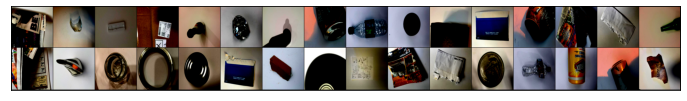

In [15]:
show_batch(train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


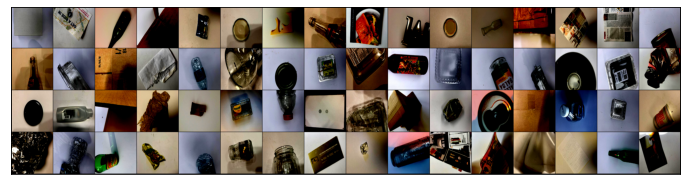

In [16]:
show_batch(val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


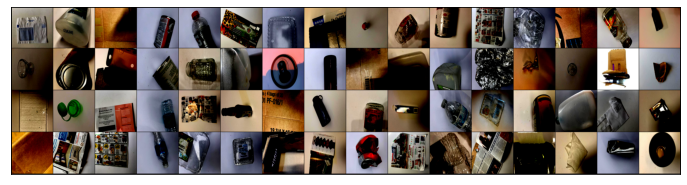

In [17]:
show_batch(test_dl)

# VGG-16


Reference1: https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

Reference2: https://debuggercafe.com/transfer-learning-with-pytorch/

## Loading Model

In [18]:
from torchvision import models
model = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [19]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Freeze weights & Update classifier

In [37]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [38]:
import torch.nn as nn
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 3000), 
                      nn.ReLU(), 
                      nn.Dropout(0.3),
                      nn.Linear(3000, 2048), 
                      nn.ReLU(), 
                      nn.Dropout(0.3),
                      nn.Linear(2048, 1024), 
                      nn.ReLU(), 
                      nn.Dropout(0.3),
                      nn.Linear(1024, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.3),
                      nn.Linear(256, len(classes)),                   
                      nn.LogSoftmax(dim=1))

In [39]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=3000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=3000, out_features=2048, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=2048, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=1024, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=6, bias=True)
    (13): LogSoftmax(dim=1)
  )
)

In [40]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [41]:
!pip install pytorch_model_summary

## Training

In [42]:
import torch
torch.cuda.empty_cache()

In [43]:
model = model.cuda()

In [44]:
from torch import optim
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# criterion = nn.MultiMarginLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.3)
optimizer = optim.Adam(model.parameters(), lr=5.5e-5)

In [45]:
def get_validaion_loss(model):
  loss = 0
  total = 0 
  with torch.no_grad():
    for data in val_dl:
        images, labels = data
        total += labels.size(0)
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss += criterion(outputs, labels).item()
  return loss / total
        # _, predicted = torch.max(outputs.data, 1)
        # total += labels.size(0)
        # correct += (predicted == labels.cuda()).sum().item()

In [46]:
training_loss = []
validaion_loss = []
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # print(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 0:    # print every ephoc
          print('Epoch: %d loss: %.3f' % (epoch + 1, running_loss/50))
          # print("val:", validaion_loss)
          training_loss.append(running_loss/50)
          validaion_loss.append(get_validaion_loss(model))
          print("val:", get_validaion_loss(model))
          running_loss = 0.0

print('Finished Training')
torch.save(model, 'baseline_model')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 loss: 0.036
val: 0.030426536094058643
Epoch: 2 loss: 0.027
val: 0.025223392654548992
Epoch: 3 loss: 0.023
val: 0.01594823090867563
Epoch: 4 loss: 0.009
val: 0.013050802729346535
Epoch: 5 loss: 0.010
val: 0.012615718286145817
Epoch: 6 loss: 0.011
val: 0.012592539191246033
Epoch: 7 loss: 0.012
val: 0.011812200939113443
Epoch: 8 loss: 0.008
val: 0.010937493971802971
Epoch: 9 loss: 0.007
val: 0.01158168302340941
Epoch: 10 loss: 0.009
val: 0.010488927364349365
Epoch: 11 loss: 0.007
val: 0.0122037526558746
Epoch: 12 loss: 0.004
val: 0.010898577218705957
Epoch: 13 loss: 0.006
val: 0.01032778298990293
Epoch: 14 loss: 0.006
val: 0.010771092704751274
Epoch: 15 loss: 0.004
val: 0.011892603540962393
Epoch: 16 loss: 0.002
val: 0.012376428666439924
Epoch: 17 loss: 0.005
val: 0.011388092217120257
Epoch: 18 loss: 0.004
val: 0.011392040008848364
Epoch: 19 loss: 0.005
val: 0.011204972524534573
Epoch: 20 loss: 0.008
val: 0.0118634548376907
Finished Training


AttributeError: ignored

In [ ]:
print(training_loss, validaion_loss)

Text(0.5, 1.0, 'VGG-16')

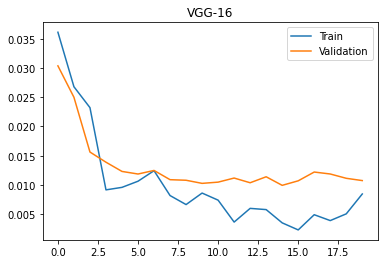

In [47]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(training_loss)
plt.plot(validaion_loss)
plt.legend(['Train', 'Validation'])
plt.title('VGG-16')

## Test

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dl)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

In [ ]:
# Test - output
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print(predicted)
# print(classes[predicted[0]])
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(predicted))))

In [ ]:
nb_classes = 6

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for inputs, classes in val_dl:
        inputs = inputs.cuda()
        classes = classes.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

# To get the per-class accuracy: precision
precision = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

recall = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(0))

f1 = 2*precision*recall/(precision+recall)
print(f1)
print("F score", f1.numpy().mean())

In [ ]:
correct = 0
total = 0
# model = model.cuda()
y_pred = []
y_true = []
with torch.no_grad():
    for data in val_dl:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()
        y_pred.append(predicted)
        y_true.append(labels)

print(100 * correct / total)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
nb_classes = 6

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for inputs, classes in train_dl:
        inputs = inputs.cuda()
        classes = classes.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

# To get the per-class accuracy: precision
precision = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

recall = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(0))

f1 = 2*precision*recall/(precision+recall)
print(f1)
print("F score", f1.numpy().mean())

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_dl:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(100 * correct / total)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
nb_classes = 6

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for inputs, classes in test_dl:
        inputs = inputs.cuda()
        classes = classes.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

# To get the per-class accuracy: precision
precision = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

recall = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(0))

f1 = 2*precision*recall/(precision+recall)
print(f1)
print("F score", f1.numpy().mean())

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(100 * correct / total)
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))